# EUKARYA

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
# import packages
import os
import re

import dokdo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qiime2 as q2
from qiime2.plugins import feature_classifier, feature_table
from qiime2.plugins.metadata.visualizers import tabulate
from qiime2.plugins.taxa.methods import filter_seqs, filter_table
from qiime2.plugins.taxa.visualizers import barplot

In [3]:
# define workdir
%env WORKDIR /home/nezapa/qiime-thesis
WORKDIR = os.environ.get("WORKDIR")

env: WORKDIR=/home/nezapa/qiime-thesis


In [4]:
# import data
denoisetable = q2.Artifact.load('./results/denoisetable.qza')
rep_seqs = q2.Artifact.load('./results/rep_seqs.qza')
denoising_stats = q2.Artifact.load('./results/denoising_stats.qza')
sample_metadata = q2.Metadata.load('../00.sample-metadata.tsv')

In [23]:
# view denoising stats
stats_df = denoising_stats.view(q2.Metadata).to_dataframe()
stats_df
#stats_df.sort_values('percentage of input passed filter')
stats_df.sort_values('percentage of input non-chimeric')

,input,filtered,percentage of input passed filter,denoised,non-chimeric,percentage of input non-chimeric
sample-id,,,,,,
P19A,23977.0,20897.0,87.15,20811.0,20753.0,86.55
P22A,39904.0,37579.0,94.17,37339.0,35340.0,88.56
P01A,49871.0,47374.0,94.99,46615.0,44604.0,89.44
P05A,23073.0,22118.0,95.86,21937.0,21117.0,91.52
P07A,21077.0,19843.0,94.15,19657.0,19359.0,91.85
P21A,23275.0,21656.0,93.04,21540.0,21395.0,91.92
P15A,15637.0,14788.0,94.57,14682.0,14502.0,92.74
P13A,28469.0,26808.0,94.17,26566.0,26435.0,92.86
P03A,31396.0,29770.0,94.82,29414.0,29249.0,93.16


## TAXONOMIC ANALYSIS

In [8]:
# load classifier data, eukarya classifier classifier-E-18S616F_18S1132R
classifier = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/classifier-E-18S616F_18S1132R.qza')
reference_reads = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/ref-seqs_18S616F_18S1132R.qza')
reference_taxonomy = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/silva-138-99-tax.qza')

In [9]:
# define model choices
models = {
    'sklearn': feature_classifier.methods.classify_sklearn,
    'vsearch': feature_classifier.methods.classify_consensus_vsearch,
    'blast': feature_classifier.methods.classify_consensus_blast,
    'hybrid': feature_classifier.pipelines.classify_hybrid_vsearch_sklearn
}

In [10]:
# choose model, run for each model_name
model_name = "hybrid"
model = models[model_name]

In [11]:
# classify the seqences using different classifiers
# run once for each model
# this step might take some time

if os.path.exists(f'./results/taxonomy_{model_name}.qza'):
    taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')
else:
    if model_name == "sklearn":
        taxonomy = model(
            reads = rep_seqs,
            classifier = classifier,
            n_jobs=4
        )
        
    elif model_name == "vsearch":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            threads = 15
        )
    elif model_name == "blast":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy
            )
    elif model_name == "hybrid":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            classifier = classifier,
            threads = 2,
            prefilter = False
            )
    else:
        print(f"model name {model_name} doesn't exist")
    
    taxonomy = taxonomy.classification
    taxonomy.save(f'./results/taxonomy_{model_name}.qza')

In [12]:
# merge all taxonomy classifications
for idx, model_name in enumerate(models.keys()):
    model_df = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza').view(pd.DataFrame)
    model_df.columns = [f'{col}_{model_name}' for col in model_df.columns]
    if idx == 0:
        res_df = model_df.copy()
    else:
        res_df = res_df.merge(model_df, on = 'Feature ID')

In [13]:
# view merged df as q2 viz
res_df_viz = q2.plugins.metadata.visualizers.tabulate(q2.Metadata(res_df)).visualization
res_df_viz.save('./results/res_df_viz.qzv')
res_df_viz

<visualization: Visualization uuid: 4a91aa11-55f6-410a-9909-9395ed9bb6ae>

In [14]:
# choose a classifier
model_name = "sklearn"
taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')

In [15]:
# load classification results of a chosen classifier as metadata and view them
taxonomy_metadata = taxonomy.view(q2.Metadata)  # or pd.DataFrame
q2.plugins.metadata.visualizers.tabulate(taxonomy_metadata).visualization

<visualization: Visualization uuid: 420b7dd2-fd6c-4d8f-b5f8-75c3ded05901>

In [16]:
### FILTER BY TAXONOMY# load rep_seqs as metadata
rep_seqs_mtdt = rep_seqs.view(q2.Metadata)

# merge dataframes in the background (appends new column)
annotated_taxonomy_metadata = taxonomy_metadata.merge(rep_seqs_mtdt)

# visualize merged dataframes as metadata viz
q2.plugins.metadata.visualizers.tabulate(annotated_taxonomy_metadata).visualization

<visualization: Visualization uuid: 33499224-f31f-48f1-aa09-f6bf6519a281>

### FILTER BY TAXONOMY

In [17]:
# filter denoisetable, keep only d__Eukaryota
denoisetable_eu = filter_table(
    table = denoisetable,
    taxonomy = taxonomy, 
    include = 'd__Eukaryota'
)
denoisetable_eu.filtered_table.save('./results/denoisetable_eu.qza')

'./results/denoisetable_eu.qza'

In [18]:
# summarise and visualise
feature_table.visualizers.summarize(
    table = denoisetable_eu.filtered_table,
    sample_metadata = sample_metadata
).visualization

<visualization: Visualization uuid: 9a14546f-1b76-4cb6-9b2c-98e11284d49b>

In [19]:
# filter rep_seqs, keep only d__Eukaryota

rep_seqs_eu = filter_seqs(
    sequences = rep_seqs,
    taxonomy = taxonomy,
    include = 'd__Eukaryota'
)
rep_seqs_eu.filtered_sequences.save('./results/rep_seqs_eu.qza')

'./results/rep_seqs_eu.qza'

### TAXA PER SPECIMEN

In [20]:
# load denoise as dataframe and transpose (feature id is index), add name to index
denoise_df = denoisetable_eu.filtered_table.view(view_type = pd.DataFrame).T
denoise_df.index.name = 'id'

# load annotated data as df
annotated_df = annotated_taxonomy_metadata.to_dataframe()

# merge the two using indices of both dataframes
merged_df = denoise_df.merge(annotated_df['Taxon'], left_index=True, right_index=True)

# set Taxon column as index and show transposed
taxon_df = merged_df.set_index('Taxon').T

In [25]:
# define functions
# define extract lvl using regex (regular expressions)
import re
def extract_level(tax, level_prefix, null_data = '/'):
    g = re.findall(fr'({level_prefix}[^;|^$]*)(?=;|$)', tax)
    if len(g) == 0:
        return null_data
    
    return g[0].replace(level_prefix, '')

# define backtrace_unassigned 
def backtrace_unassigned(row, unassigned_like_words, invalid_words):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    try:
        valid_name = [val for val in row[columns].values if val not in invalid_words][-1]
        row[columns] = [val if val not in invalid_words else f"Unclass._{valid_name}" for val in row[columns].values]
        
        valid_name = [val for val in row[columns].values if val not in unassigned_like_words][-1]
        row[columns] = [val if val not in unassigned_like_words else f"Unclass._{valid_name}_{val}" for val in row[columns].values]
    except:
        pass
    return row

# define reassemble taxon column
def reassemble_taxon(row):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    prefixes = ['d__', 'p__', 'c__', 'o__', 'f__', 'g__']
    return ";".join(["".join(pair) for pair in zip(prefixes, row[columns].values)])


# remove duplicates
def remove_duplicates(row):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    try:
        unique_values, counts = np.unique(row[columns].values, return_counts=True)
        duplicate_id = np.where(counts > 1)[0][0] if any(counts > 1) else None
        
        if duplicate_id is not None:
            count = counts[duplicate_id]
            duplicate_str = unique_values[duplicate_id]
            joined_str = '|'.join(row[columns].values[::-1])
            row[columns] = re.sub(duplicate_str, f'Unclass._{duplicate_str}', joined_str, count=count-1).split('|')[::-1]
    except:
        pass
    return row

In [26]:
# run once for each sample (subject)
# choose a sample 
subject = 'P11A'
taxon_df.loc[[subject]].T.reset_index().query(f'{subject} > 0.0').value_counts('Taxon')

# define custom_df, get rid of Unassigned
custom_df = taxon_df.loc[[subject]].T.reset_index()
custom_df = custom_df.query(f'Taxon != "Unassigned" and {subject} > 0')

custom_df['Domain'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='d__', null_data='Unassigned'))
custom_df['Phylum'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='p__', null_data='Unassigned'))
custom_df['Class'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='c__', null_data='Unassigned'))
custom_df['Order'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='o__', null_data='Unassigned'))
custom_df['Family'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='f__', null_data='Unassigned'))
custom_df['Genus'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='g__', null_data='Unassigned'))
#custom_df['Species'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='s__'))

invalid_words = ["uncultured", "Unassigned"]
unassigned_like_words = ['P34.45']
custom_df = custom_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

custom_df['Taxon'] = custom_df.apply(reassemble_taxon, axis=1)


columns = ['Phylum', 'Class', 'Order', 'Family', 'Genus']#, 'Species']
# columns = ['Order', 'Family', 'Genus', 'Species']
taxa_per_species = custom_df.groupby(columns).sum()
print(taxa_per_species.to_latex(escape=False))

#taxa_per_species

\begin{tabular}{lllllr}
\toprule
           &                     &                     &                     &                     &     P11A \\
Phylum & Class & Order & Family & Genus &          \\
\midrule
Cercozoa & Glissomonadida & Glissomonadida & Glissomonadida & Heteromita &    349.0 \\
Ciliophora & Intramacronucleata & Conthreep & Phyllopharyngea & Chilodonella &     41.0 \\
Euglenozoa & Kinetoplastea & Neobodonida & Neobodonida & Neobodo &    145.0 \\
Heterolobosea & Tetramitia & Tetramitia & Tetramitia & Naegleria &   1598.0 \\
Ochrophyta & Chrysophyceae & Chromulinales & Chromulinales & Spumella &   1065.0 \\
           &                     &                     &                     & Unclass._Chromulinales &    747.0 \\
           &                     & Chrysophyceae & Chrysophyceae & Chrysophyceae &     86.0 \\
           &                     & Ochromonadales & Ochromonadales & Ochromonas &   1704.0 \\
           &                     &                     &          

### VISUALIZATIONS

In [27]:
import numpy as np

# prepare new_taxonomy file with taxonomy corrections, same as above
taxonomy_df = taxonomy.view(pd.DataFrame)

taxonomy_df['Domain'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='d__', null_data='Unassigned')
taxonomy_df['Phylum'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='p__', null_data='Unassigned')
taxonomy_df['Class'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='c__', null_data='Unassigned')
taxonomy_df['Order'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='o__', null_data='Unassigned')
taxonomy_df['Family'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='f__', null_data='Unassigned')
taxonomy_df['Genus'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='g__', null_data='Unassigned')

invalid_words = ["uncultured", "Unassigned"]
unassigned_like_words = ['P34.45']
taxonomy_df = taxonomy_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

taxonomy_df = taxonomy_df.apply(remove_duplicates, axis=1)

taxonomy_df['Taxon'] = taxonomy_df.apply(reassemble_taxon, axis=1)
taxonomy_df.drop(columns=['Taxon'])

new_taxonomy = q2.Artifact.import_data("FeatureData[Taxonomy]", taxonomy_df)

In [30]:
new_taxonomy_df = new_taxonomy.view(view_type = pd.DataFrame)
new_taxonomy_df

,Taxon,Confidence,Domain,Phylum,Class,Order,Family,Genus
Feature ID,,,,,,,,
b341e88159d9fa2afaebabad080dcaca,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.9937498005091848,Eukaryota,Vertebrata,Amphibia,Unclass._Amphibia,Unclass._Amphibia,Unclass._Amphibia
9879093aa4a399313ec90efc8bc1c337,d__Eukaryota;p__Platyhelminthes;c__Monogenea;o...,0.8734461051448057,Eukaryota,Platyhelminthes,Monogenea,Monopisthocotylea,Gyrodactylidae,Unclass._Gyrodactylidae
a48da955f26312b4d1b42fc7bc19c728,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,0.9622221105177953,Bacteria,Acidobacteriota,Vicinamibacteria,Vicinamibacterales,Unclass._Vicinamibacterales,Unclass._Unclass._Vicinamibacterales
733d36e9dd7685ce2c24c03bc2bd74d5,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.96749823368818,Eukaryota,Vertebrata,Amphibia,Unclass._Amphibia,Unclass._Amphibia,Unclass._Amphibia
a3c3abf4643727f52f42d700603e09d9,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.9917070760095792,Eukaryota,Vertebrata,Amphibia,Unclass._Amphibia,Unclass._Amphibia,Unclass._Amphibia
...,...,...,...,...,...,...,...,...
8a40acc3ab1adea90e53b5b5b9e0641b,d__Eukaryota;p__Vertebrata;c__Unclass._Vertebr...,0.9993339125461939,Eukaryota,Vertebrata,Unclass._Vertebrata,Unclass._Unclass._Vertebrata,Unclass._Unclass._Vertebrata,Unclass._Unclass._Vertebrata
016997508d7cb821d034c422221ad21c,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.805266643255089,Eukaryota,Vertebrata,Amphibia,Unclass._Amphibia,Unclass._Amphibia,Unclass._Amphibia
1ea1ef8e2163e551656deafa69d44ae7,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.9764746773661873,Eukaryota,Vertebrata,Amphibia,Unclass._Amphibia,Unclass._Amphibia,Unclass._Amphibia


In [84]:
# popravi! napake

# subset that contains certain string
#dfx = df2[df2['Class'].str.contains('Unclass.', na = False)]
new_taxonomy_df['Domain'].unique()
df2=new_taxonomy_df.query("Domain == 'Eukaryota'")
#df2= df2[df2["Phylum"].str.contains('Unclass.')==False]
# #df2["Phylum"].unique()
# # subset that doesn't contain certain string
df3 = df2[df2["Class"].str.contains('Unclass.')==False]
# #df3["Class"].unique()
df4 = df3[df3["Order"].str.contains('Unclass.')==False]
# #df4["Order"].nunique()
df5 = df4[df4["Family"].str.contains('Unclass.')==False]
# #df5["Family"].unique()
#df6 = df5[df5["Genus"].str.contains('Unclass.')==False]
# df6['Genus'].unique()

In [92]:
df3= df2[df2["Phylum"].str.contains('Unclass.')==False]
df2["Family"].unique()

array(['Unclass._Amphibia', 'Gyrodactylidae', 'Phyllopharyngea',
       'Unclass._Tetramitia', 'Unclass._Ochromonadales',
       'Oligohymenophorea', 'Unclass._Bacillariophyceae',
       'Unclass._Incertae_Sedis', 'Unclass._Unclass._Chrysophyceae',
       'Unclass._Chromulinales', 'Chromulinales',
       'Unclass._Unclass._Vertebrata', 'Unclass._Monhysterida',
       'Unclass._Unclass._Chrysophyceae_P34.45', 'Incertae_Sedis',
       'Unclass._Glissomonadida', 'Unclass._Neobodonida',
       'Unclass._Chrysophyceae', 'Unclass._Unclass._Eukaryota',
       'Unclass._Ancyromonadida', 'Hypocreaceae',
       'Unclass._Heterobranchia', 'Cordycipitaceae',
       'Unclass._Russulales', 'Unclass._Unclass._Agaricomycetes'],
      dtype=object)

In [107]:
# visualise classifications in qiime2
taxa_bar_plot = barplot(
    table = denoisetable_eu.filtered_table,
    taxonomy = new_taxonomy,
    metadata = sample_metadata
).visualization

In [108]:
# save taxa_bar_plot in results folder
taxa_bar_plot.save('./results/taxa_bar_plots.qzv')

'./results/taxa_bar_plots.qzv'

In [109]:
# visualise taxa bar plot - interacive taxa bar plot visualisation
taxa_bar_plot

<visualization: Visualization uuid: 12d497f9-1b40-4bf2-8d88-4c192f96e49f>

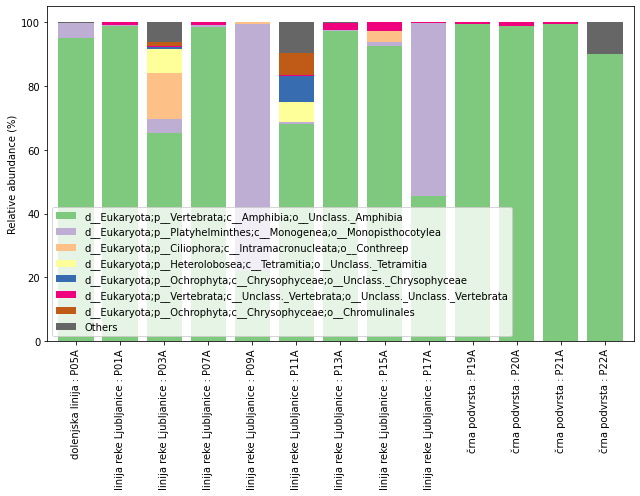

In [110]:
# taxa abundance plot with dokdo
dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    level=4,
    count=8,
    figsize=(9, 7),
    by=['population'],
    label_columns=['population', 'sample-id'],
    sort_by_mean2=False
)

plt.tight_layout()

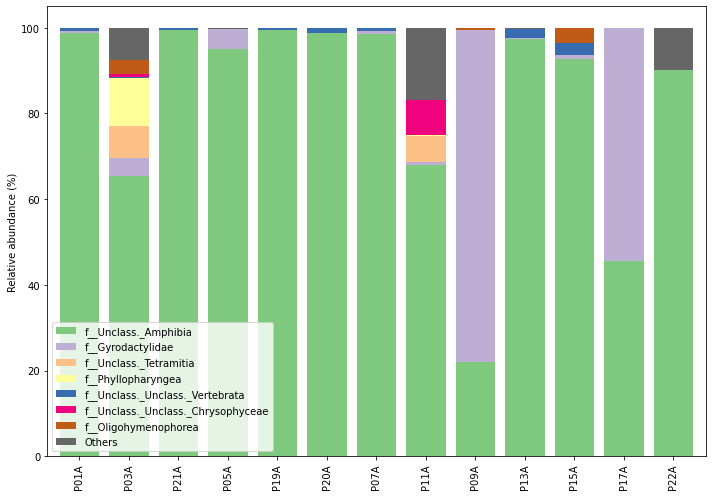

In [111]:
# show 7 most abundant genera plus 'Others' with count = 8
dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(10, 7),
    level=5,
    count=8,
    legend_short=True,
    by=['year'],
    label_columns=['sample-id'],
    sort_by_mean2=False
)

plt.tight_layout()

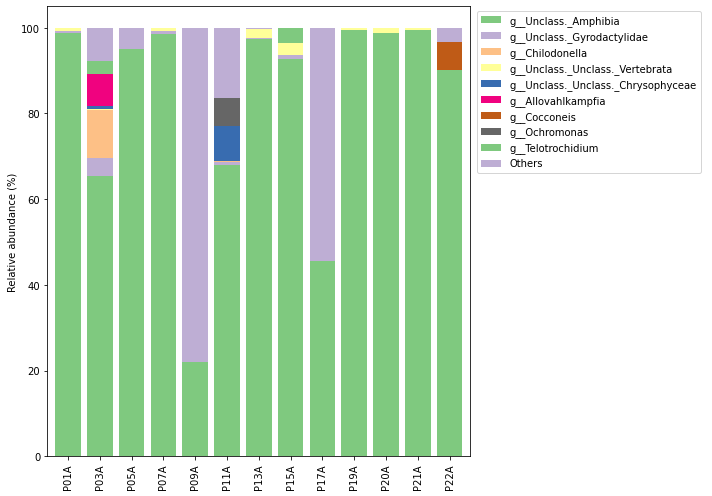

In [112]:
# plot the legent separately
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=10,
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=10,
    legend_short=True
)

handles, labels = ax2.get_legend_handles_labels()

ax2.clear()
ax2.legend(handles, labels)
ax2.axis('off')

plt.tight_layout()

In [113]:
def label_filter(lbl):
    if lbl.count(';') == 0:
        return lbl
    
    lbl_split = lbl.split(';')
    
    new_label = []
    for piece in lbl_split[::-1]:
        new_label.append(piece)
        if 'uncultured' not in piece and piece != '__':
            break
            
    return ';'.join(new_label[::-1][:2])

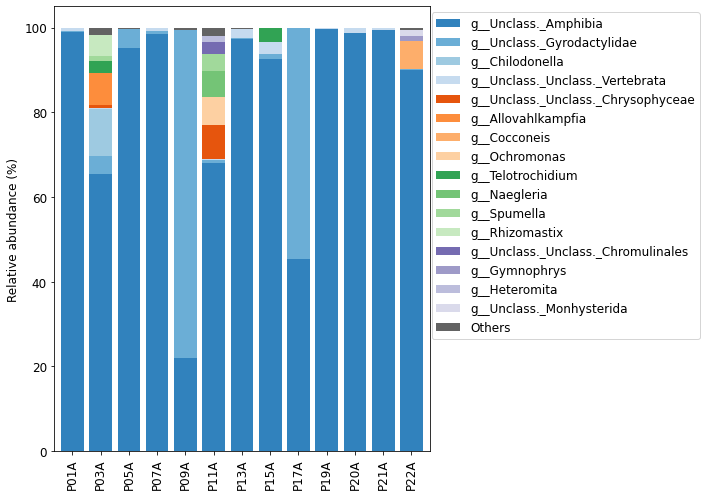

In [114]:
# use a different colour map
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=17,
    cmap_name='tab20c',
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=17,
    cmap_name='tab20c',
    legend_short=False
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

# custom properties
ax1.tick_params(labelsize=12)  # reset rotation
ax1.yaxis.label.set_size(12)


ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

plt.tight_layout()
plt.savefig('./results/proteus_all_16taxa.png')

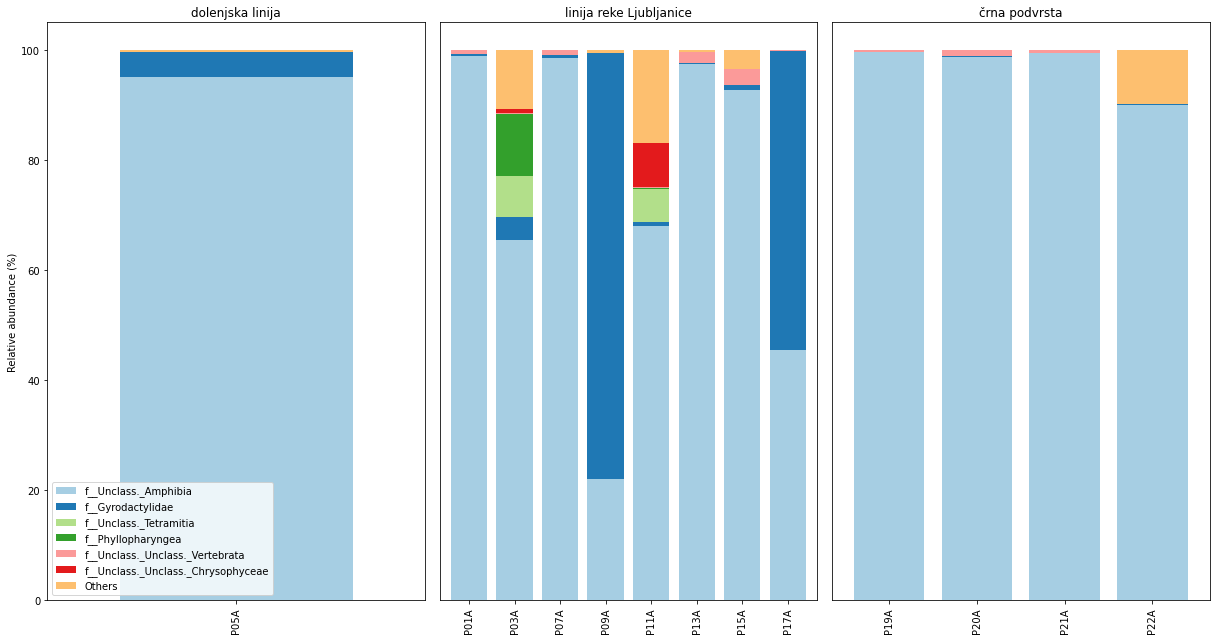

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(17, 9))

groups = ['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta']
kwargs = dict(level=5, count=7, sort_by_mean2=False)

for i, group in enumerate(groups):
    dokdo.taxa_abundance_bar_plot(
        taxa_bar_plot,
        ax=axes[i],
        include_samples={'population': [group]},
        cmap_name='Paired',
        legend_short=True,
        legend=True if i == 0 else False,
        **kwargs # da razbije dictionary se uporabi **
    )
    if i != 0:
        axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(group)

    # custom properties
#     axes.tick_params(labelrotation = 0, labelsize=15)  # reset rotation
#     axes.yaxis.label.set_size(15)
    
    
plt.tight_layout()
plt.savefig('./results/proteus_all_populations_eukarya.png')

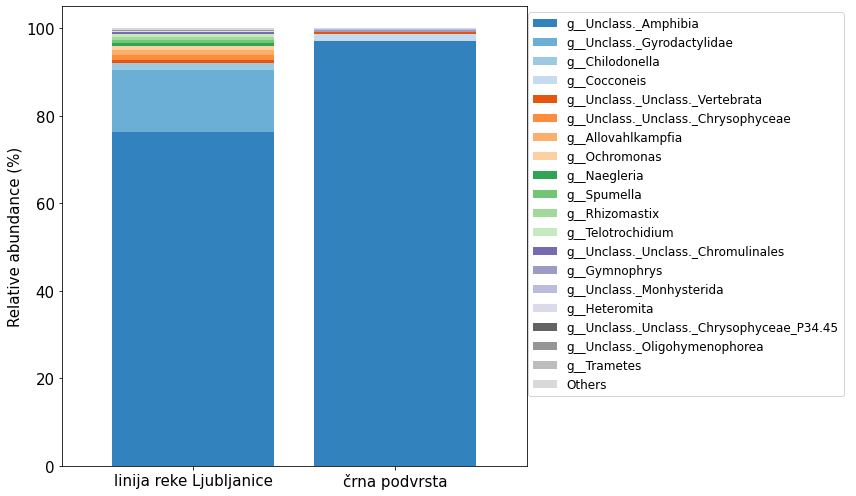

In [118]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend=False,
    cmap_name='tab20c'
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend_short=True,
    cmap_name='tab20c'
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

# custom properties
ax1.tick_params(labelrotation = 0, labelsize=15)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/proteus_all_populations_together_euk.png')

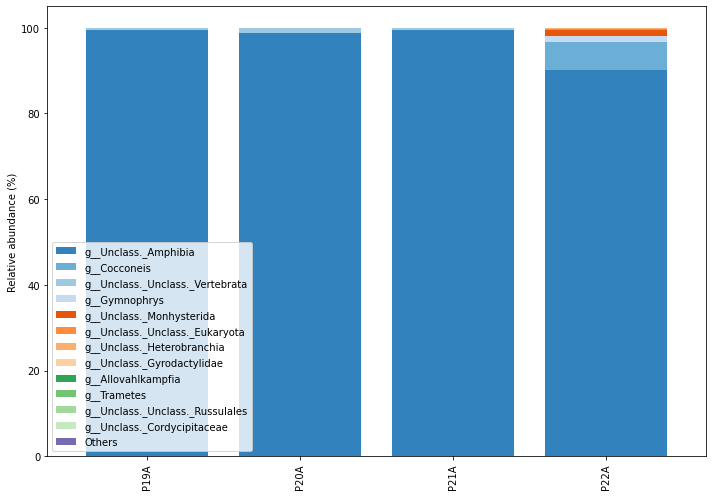

In [121]:
kwargs = dict(
    include_samples={'population': ['črna podvrsta']},
    label_columns=['sample-id'],
    level=6,
    count=13
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(10, 7),
    cmap_name='tab20c',
    legend_short=True,
    **kwargs
)

#handles, labels = ax2.get_legend_handles_labels()

# ax2.clear()
# ax2.legend(handles, labels)
# ax2.axis('off')

plt.tight_layout()
plt.savefig('./results/ba_crni_primerjava10najpogostejsih_euk.png')